In [162]:
%matplotlib notebook
import numpy as np
import io
import sys
import matplotlib.pyplot as plt
import time

In [2]:
def lasso_solve( A, d, la_array ):
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    w = np.zeros((n,1))
    num_lam = len(la_array)
    X = np.zeros((n, num_lam))
    for i, each_lambda in enumerate(la_array):
        for j in range(max_iter):
            z = w - tau*(A.T@(A@w-d))
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*each_lambda/2, 0, np.inf)
            X[:, i:i+1] = w
            if np.linalg.norm(w - w_old) < tol:
                break
    return X

In [21]:
# read in the training data
trainImages = io.open('train-images.idx3-ubyte', 'rb')
trainLabels = io.open('train-labels.idx1-ubyte', 'rb')

In [22]:
magic = int.from_bytes(trainImages.read(4), byteorder='big')
if magic != 2051:
    sys.exit('Wrong magic number for train-images.idx3-ubyte')
    
magic = int.from_bytes(trainLabels.read(4), byteorder='big')
if magic != 2049:
    sys.exit('Wrong magic number for train-labels.idx3-ubyte')

imageNum = int.from_bytes(trainImages.read(4), byteorder='big')
labelNum = int.from_bytes(trainLabels.read(4), byteorder='big')

num = min(imageNum, labelNum)

# dimensions of each image
rowNum = int.from_bytes(trainImages.read(4), byteorder='big')
colNum = int.from_bytes(trainImages.read(4), byteorder='big')

images = np.zeros(num*colNum*rowNum).reshape(num, colNum*rowNum)
for i in range(num):
    for j in range(colNum*rowNum):
        images[i, j] = int.from_bytes(trainImages.read(1), byteorder='big', signed=False)

labels = np.zeros(num)
for i in range(num):
    labels[i] = int.from_bytes(trainLabels.read(1), byteorder='big', signed=False)

trainImages.close()
trainLabels.close()

In [23]:
# read in the test data
testImages = io.open('t10k-images.idx3-ubyte', 'rb')
testLabels = io.open('t10k-labels.idx1-ubyte', 'rb')

In [24]:
magicT = int.from_bytes(testImages.read(4), byteorder='big')
if magicT != 2051:
    sys.exit('Wrong magic number for t10k-images.idx3-ubyte')
    
magicT = int.from_bytes(testLabels.read(4), byteorder='big')
if magicT != 2049:
    sys.exit('Wrong magic number for t10k-labels.idx3-ubyte')

imageNumT = int.from_bytes(testImages.read(4), byteorder='big')
labelNumT = int.from_bytes(testLabels.read(4), byteorder='big')

numT = min(imageNumT, labelNumT)

# dimensions of each image
rowNumT = int.from_bytes(testImages.read(4), byteorder='big')
colNumT = int.from_bytes(testImages.read(4), byteorder='big')

imagesT = np.zeros(numT*colNumT*rowNumT).reshape(numT, colNumT*rowNumT)
for i in range(numT):
    for j in range(colNumT*rowNumT):
        imagesT[i, j] = int.from_bytes(testImages.read(1), byteorder='big', signed=False)

labelsT = np.zeros(numT)
for i in range(numT):
    labelsT[i] = int.from_bytes(testLabels.read(1), byteorder='big', signed=False)

testImages.close()
testLabels.close()

# cross validation

In [26]:
index = list(range(60000))
groups = [index[0:10000], index[10000:20000], index[20000:30000], index[30000:40000], index[40000:50000], index[50000:60000]]

k = np.arange(-10,21, dtype=float)

trainImages = images[0:50000, :]
trainLabels = labels[0:50000].reshape(50000, 1)
selectImages = images[50000:60000, :]
selectLabels = labels[50000:60000].reshape(10000, 1)

errorRate = np.zeros(k.shape[0])
errorRateFinal = np.zeros(k.shape[0])

X = lasso_solve(trainImages, trainLabels, 2**(k))

for i in range(k.shape[0]):
    w = X[:, i:i+1]
    labelsHat = np.around(np.clip(selectImages@w, 0, 9))
    errorRate[i] = 1 - np.sum(labelsHat == selectLabels) / selectLabels.shape[0]
    
    labelsHat = np.around(np.clip(imagesT@w, 0, 9))
    errorRateFinal[i] = 1 - np.sum(labelsHat == labelsT.reshape(10000,1)) / numT

print('final error rate: ', errorRateFinal[np.argmin(errorRate)])

final error rate:  0.8301000000000001


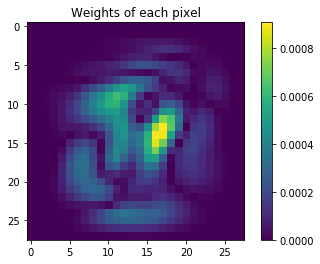

In [27]:
plt.figure()
plt.imshow(np.absolute(X[:,np.argmin(errorRate)].reshape(rowNum, colNum)))
plt.colorbar()
plt.title('Weights of each pixel')
plt.show()

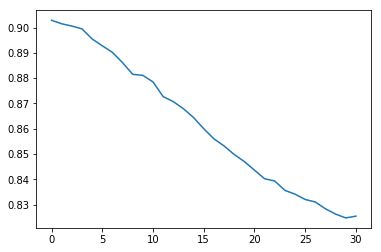

index of optimal lambda: 29


In [28]:
plt.figure()
plt.plot(errorRate)
plt.show()
print('index of optimal lambda:',np.argmin(errorRate))

# remove the unimportant pixels then cross validation

In [29]:
# get the index of weights greater than 0.0001
w = X[:, 29]
select = np.argwhere(w>0.0007)[:,0]

trainImages = images[0:50000,select]
trainLabels = labels[0:50000].reshape(50000, 1)
selectImages = images[50000:60000, select]
selectLabels = labels[50000:60000].reshape(10000, 1)

imagesTest = imagesT[:, select]

errorRate = np.zeros(k.shape[0])
errorRateFinal = np.zeros(k.shape[0])

X1 = lasso_solve(trainImages, trainLabels, 2**(k))

for i in range(k.shape[0]):
    w = X1[:, i:i+1]
    labelsHat = np.around(np.clip(selectImages@w, 0, 9))
    errorRate[i] = 1 - np.sum(labelsHat == selectLabels) / selectLabels.shape[0]
    
    labelsHat = np.around(np.clip(imagesTest@w, 0, 9))
    errorRateFinal[i] = 1 - np.sum(labelsHat == labelsT.reshape(10000,1)) / numT

print('final error rate: ', errorRateFinal[np.argmin(errorRate)])

final error rate:  0.7979


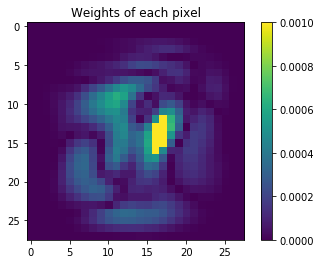

In [30]:
plt.figure()
w = np.absolute(X[:,29])
w[select] = 0.001
plt.imshow(w.reshape(rowNum, colNum))
plt.colorbar()
plt.title('Weights of each pixel')
plt.show()

# train a classifier for each digit

In [32]:
unique, counts = np.unique(labels, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


In [91]:
# to record the weight for each digit
W = np.zeros((rowNum*colNum, 10))

for j in range(10):
    # data set for training
    trainLa = np.copy(labels[0:50000])
    l1 = np.argwhere(trainLa==j)
    l2 = np.argwhere(trainLa!=j)
    trainLa[l1] = +1
    trainLa[l2] = -1
    trainLa = trainLa.reshape(50000,1)
    
    trainImages = images[0:50000, :]
    
    # data set for tuning the parameter
    selectLa = np.copy(labels[50000:60000])
    l1 = np.argwhere(selectLa==j)
    l2 = np.argwhere(selectLa!=j)
    selectLa[l1] = +1
    selectLa[l2] = -1
    selectLa = selectLa.reshape(10000,1)
    
    selectImages = images[50000:60000, :]
    
    # data set for final test
    testLa = np.copy(labelsT)
    l1 = np.argwhere(testLa==j)
    l2 = np.argwhere(testLa!=j)
    testLa[l1] = +1
    testLa[l2] = -1
    testLa = testLa.reshape(10000,1)
    
    errorRate = np.zeros(k.shape[0])
    errorRateFinal = np.zeros(k.shape[0])

    X2 = lasso_solve(trainImages, trainLa, 2**(k))
    
    for i in range(k.shape[0]):
        w = X2[:, i:i+1]
        labelsHat = np.sign(selectImages@w)
        errorRate[i] = 1 - np.sum(labelsHat == selectLa) / selectLa.shape[0]

        labelsHat = np.sign(imagesT@w)
        errorRateFinal[i] = 1 - np.sum(labelsHat == testLa) / numT

    W[:,j] = X2[:, np.argmin(errorRate)]
    print('final error rate of ', j, 'is: ', errorRateFinal[np.argmin(errorRate)])

final error rate of  0 is:  0.022499999999999964
final error rate of  1 is:  0.020299999999999985
final error rate of  2 is:  0.0685
final error rate of  3 is:  0.06669999999999998
final error rate of  4 is:  0.06899999999999995
final error rate of  5 is:  0.08919999999999995
final error rate of  6 is:  0.03820000000000001
final error rate of  7 is:  0.04090000000000005
final error rate of  8 is:  0.09760000000000002
final error rate of  9 is:  0.10019999999999996


In [127]:
labelsHat = imagesT@W
labelsHat = np.absolute(labelsHat - np.ones(labelsHat.shape))
labelsHat = np.argmin(labelsHat, axis=1).reshape(10000,1)
print('error rate: ', 1- np.sum(labelsHat.flatten() == labelsT) / numT)

error rate:  0.18430000000000002


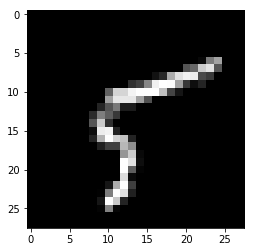

5.0


In [146]:
index = 59
sample = imagesT[index].reshape(rowNum, colNum)

fig = plt.figure()
plt.imshow(sample, cmap='gray')
plt.show()
print(labelsT[index])

<IPython.core.display.Javascript object>


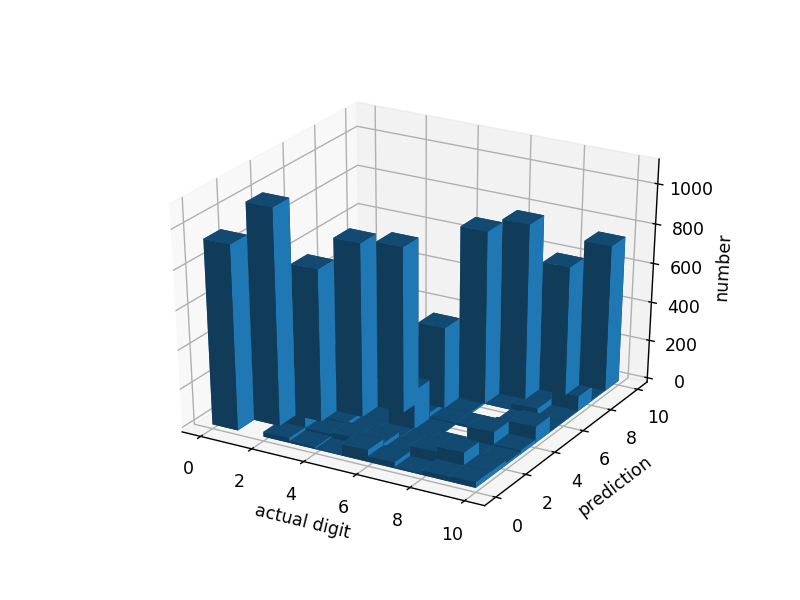

In [167]:
from mpl_toolkits.mplot3d import Axes3D

unique, counts = np.unique(np.hstack((labelsT.reshape(10000,1), labelsHat)), axis=0, return_counts=True)
#print(np.hstack((unique, counts.reshape(87,1))).astype(int))

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

x3 = unique[:,0]
y3 = unique[:,1]
z3 = np.zeros(87)

dx = np.ones(87)
dy = np.ones(87)
dz = counts

ax1.bar3d(x3, y3, z3, dx, dy, dz)


ax1.set_xlabel('actual digit')
ax1.set_ylabel('prediction')
ax1.set_zlabel('number')

plt.show()

<IPython.core.display.Javascript object>


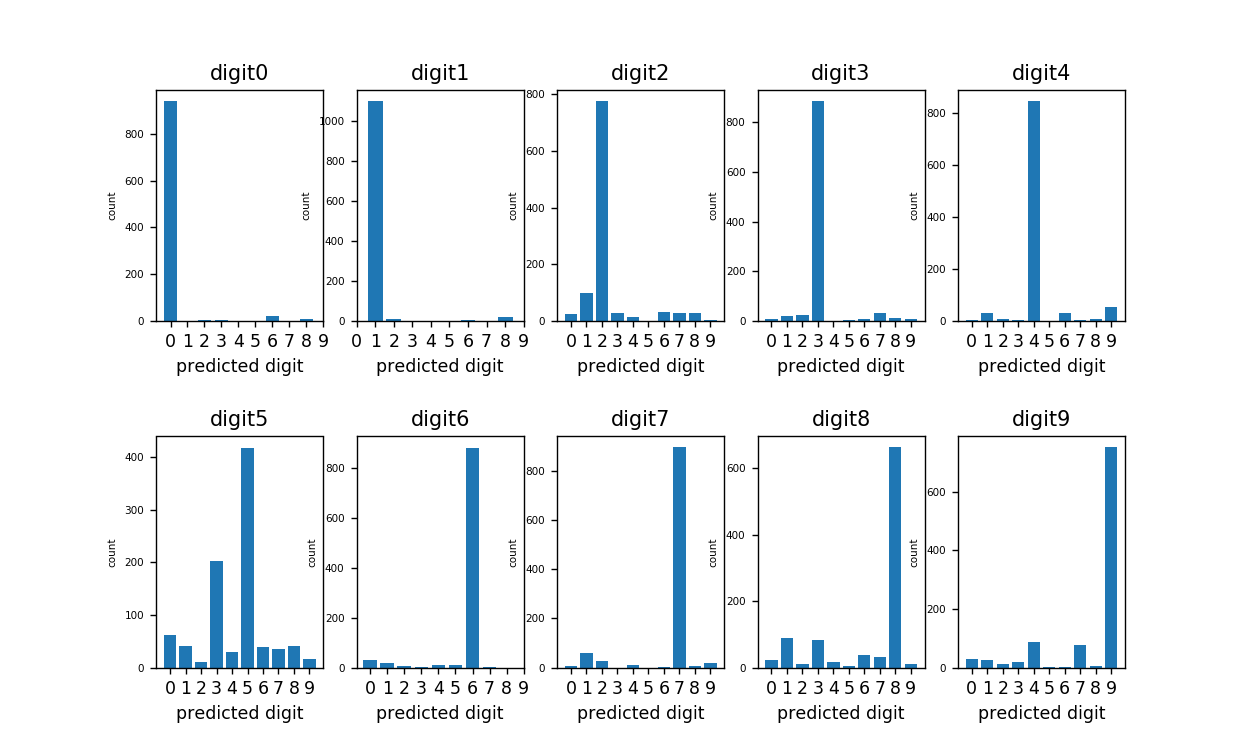

In [186]:
fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    actual = unique[:,0]
    prediction = unique[:,1]
    ax.bar(prediction[actual==i], counts[actual==i])
    plt.xticks(np.arange(0,10))
    plt.yticks(fontsize=6)
    ax.set_xlabel('predicted digit')
    ax.set_ylabel('count', fontsize=6)
    ax.title.set_text('digit'+ str(i))
plt.show()

<IPython.core.display.Javascript object>


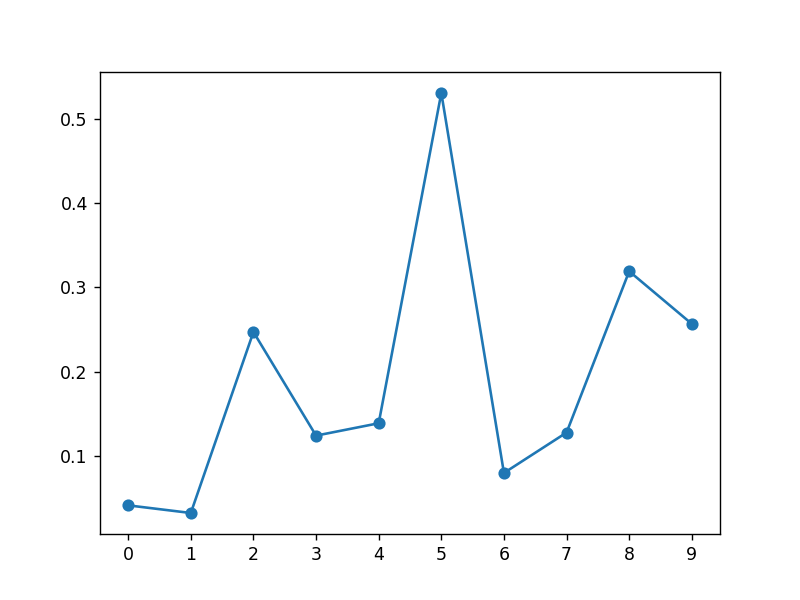

In [198]:
errorRate = []
for i in range(10):
    l = np.argwhere(unique[:, 0]==i)
    temp1 = counts[l.flatten()]
    total = np.sum(temp1)
    temp2 = unique[l.flatten(), :][:,1]
    error = total - temp1[temp2==i]
    errorRate.append(error/total)

fig = plt.figure()
plt.plot(np.arange(0,10), errorRate, marker='o')
plt.xticks(np.arange(0,10))
plt.show()

In [194]:
print(unique[1:3, :][:,1])
print(l)

[2. 3.]
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


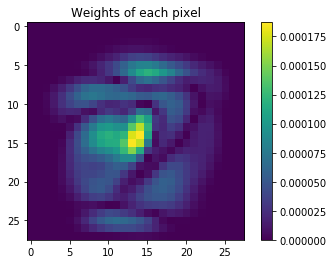

In [142]:
plt.figure()
plt.imshow(np.absolute(W[:,7].reshape(rowNum, colNum)))
plt.colorbar()
plt.title('Weights of each pixel')
plt.show()

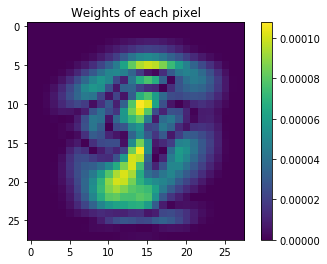

In [143]:
plt.figure()
plt.imshow(np.absolute(W[:,9].reshape(rowNum, colNum)))
plt.colorbar()
plt.title('Weights of each pixel')
plt.show()

In [89]:
# build a training data set for each digit with 1000 images each, half of which are exactly the digit, half of which are not
digitIndex = list()
for i in range(10):
    index = np.ndarray.tolist(np.argwhere(labels==i).flatten())
    digitIndex.append(index)

n = 500

W = np.zeros((rowNum*colNum, 10))

for i in range(10):
    # build the train data set
    trainList = []
    for j in range(10):
        if (j==i):
            trainList = trainList + digitIndex[j][0:9*n]
        else:
            trainList = trainList + digitIndex[j][0:n]
    
    np.random.shuffle(trainList)
    
    trainImages = images[trainList[0:15*n], :]
    trainLabels = np.copy(labels[trainList[0:15*n]])
    l1 = np.argwhere(trainLabels==i)
    l2 = np.argwhere(trainLabels!=i)
    trainLabels[l1] = +1
    trainLabels[l2] = -1
    trainLabels = trainLabels.reshape(15*n, 1)
    
    selectImages = images[trainList[15*n:18*n], :]
    selectLabels = np.copy(labels[trainList[15*n:18*n]])
    l1 = np.argwhere(selectLabels==i)
    l2 = np.argwhere(selectLabels!=i)
    selectLabels[l1] = +1
    selectLabels[l2] = -1
    selectLabels = selectLabels.reshape(3*n, 1)
    
    testLabels = np.copy(labelsT)
    l1 = np.argwhere(testLabels==i)
    l2 = np.argwhere(testLabels!=i)
    testLabels[l1] = +1
    testLabels[l2] = -1
    testLabels = testLabels.reshape(10000,1)
    
    errorRate = np.zeros(k.shape[0])
    errorRateFinal = np.zeros(k.shape[0])

    X3 = lasso_solve(trainImages, trainLabels, 2**(k))
    
    for ii in range(k.shape[0]):
        w = X3[:, ii:ii+1]
        labelsHat = np.sign(selectImages@w)
        errorRate[ii] = 1 - np.sum(labelsHat == selectLabels) / selectLabels.shape[0]

        labelsHat = np.sign(imagesT@w)
        errorRateFinal[ii] = 1 - np.sum(labelsHat == testLabels) / numT

    W[:,i] = X3[:, np.argmin(errorRate)]
    
    print('final error rate of ', i, 'is: ', errorRateFinal[np.argmin(errorRate)])

final error rate of  0 is:  0.0353
final error rate of  1 is:  0.03259999999999996
final error rate of  2 is:  0.08140000000000003
final error rate of  3 is:  0.09819999999999995
final error rate of  4 is:  0.12350000000000005
final error rate of  5 is:  0.134
final error rate of  6 is:  0.048699999999999966
final error rate of  7 is:  0.05120000000000002
final error rate of  8 is:  0.20989999999999998
final error rate of  9 is:  0.19430000000000003
